<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Basic/Gender_by_voice_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rosenblatt's perceptron 
#Gender recognition by voice

Let's import some necessary libs and files first

In [221]:
!wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Basic/data/voice.csv

--2023-04-22 20:49:23--  https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Basic/data/voice.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1065381 (1.0M) [text/plain]
Saving to: ‘voice.csv.4’

voice.csv.4         100%[===================>]   1.02M  --.-KB/s    in 0.06s   

2023-04-22 20:49:24 (18.1 MB/s) - ‘voice.csv.4’ saved [1065381/1065381]



In [222]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.linear_model import Perceptron as skPerceptron
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, accuracy_score,f1_score, recall_score,precision_score
from sklearn.model_selection import train_test_split

In [223]:
df = pd.read_csv("voice.csv")

## EDA

### What does dataset look like

In [224]:
df.columns

Index(['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt',
       'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun',
       'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label'],
      dtype='object')

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

Looks like thats some statstically measured data, distribution analysis. 
All numeric columns except our target.

### What does our target look like?

In [226]:
df['label'].unique()

array(['male', 'female'], dtype=object)

In [227]:
df['label'].value_counts()

male      1584
female    1584
Name: label, dtype: int64

We got two categories, equally distributed. Nice.

### Check stats for parameters

In [228]:
df.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


In [229]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [230]:
df.tail()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
3163,0.131884,0.084734,0.153707,0.049285,0.201144,0.151859,1.762129,6.630383,0.962934,0.763182,...,0.131884,0.182790,0.083770,0.262295,0.832899,0.007812,4.210938,4.203125,0.161929,female
3164,0.116221,0.089221,0.076758,0.042718,0.204911,0.162193,0.693730,2.503954,0.960716,0.709570,...,0.116221,0.188980,0.034409,0.275862,0.909856,0.039062,3.679688,3.640625,0.277897,female
3165,0.142056,0.095798,0.183731,0.033424,0.224360,0.190936,1.876502,6.604509,0.946854,0.654196,...,0.142056,0.209918,0.039506,0.275862,0.494271,0.007812,2.937500,2.929688,0.194759,female
3166,0.143659,0.090628,0.184976,0.043508,0.219943,0.176435,1.591065,5.388298,0.950436,0.675470,...,0.143659,0.172375,0.034483,0.250000,0.791360,0.007812,3.593750,3.585938,0.311002,female
3167,0.165509,0.092884,0.183044,0.070072,0.250827,0.180756,1.705029,5.769115,0.938829,0.601529,...,0.165509,0.185607,0.062257,0.271186,0.227022,0.007812,0.554688,0.546875,0.350000,female


Labels here are ordered so we'll need to shuffle the data

array([[<Axes: title={'center': 'meanfreq'}>,
        <Axes: title={'center': 'sd'}>,
        <Axes: title={'center': 'median'}>,
        <Axes: title={'center': 'Q25'}>],
       [<Axes: title={'center': 'Q75'}>, <Axes: title={'center': 'IQR'}>,
        <Axes: title={'center': 'skew'}>,
        <Axes: title={'center': 'kurt'}>],
       [<Axes: title={'center': 'sp.ent'}>,
        <Axes: title={'center': 'sfm'}>,
        <Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'centroid'}>],
       [<Axes: title={'center': 'meanfun'}>,
        <Axes: title={'center': 'minfun'}>,
        <Axes: title={'center': 'maxfun'}>,
        <Axes: title={'center': 'meandom'}>],
       [<Axes: title={'center': 'mindom'}>,
        <Axes: title={'center': 'maxdom'}>,
        <Axes: title={'center': 'dfrange'}>,
        <Axes: title={'center': 'modindx'}>]], dtype=object)

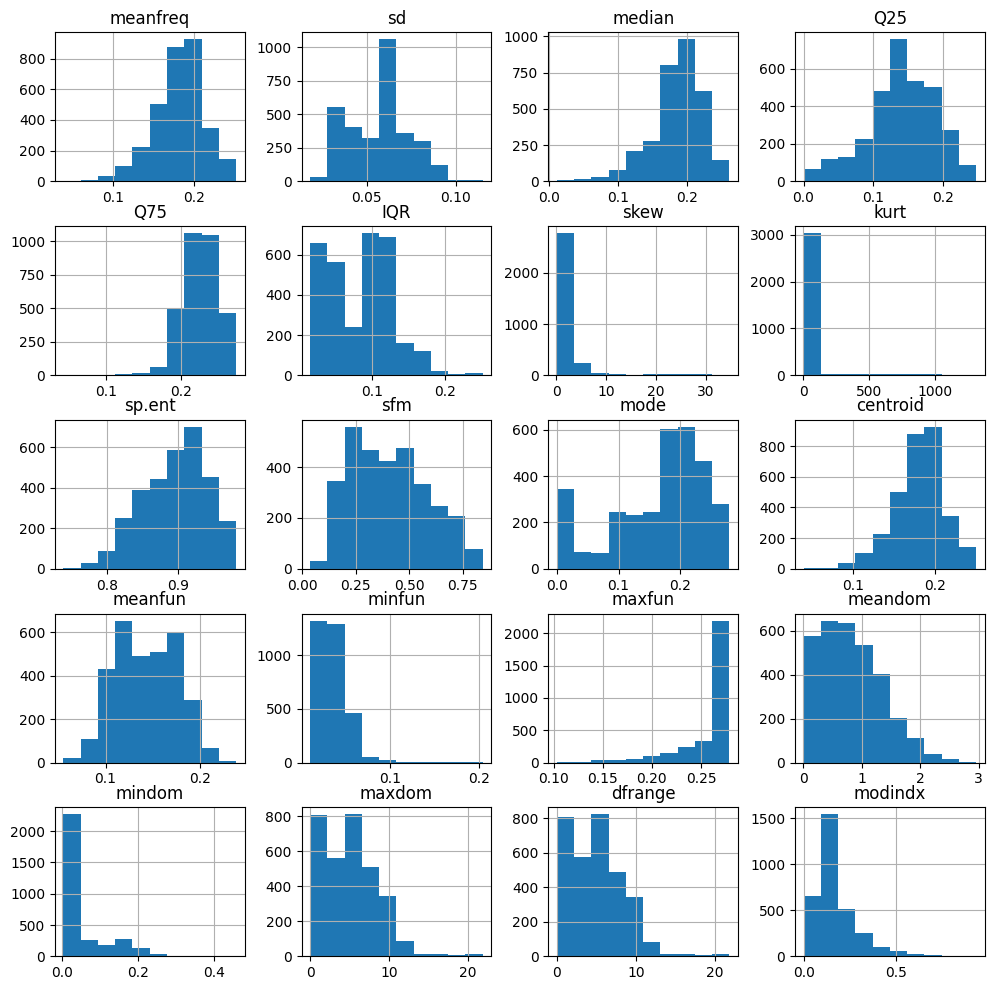

In [231]:
df.hist(df.columns, figsize=(12, 12))

We can see some skewedness here, some binomial dist, some outliers. but due to the character of our task we are likely not to change the shape of the data. No log, root, cutting IQR outliers, etc.

### Do we have duplicates?

In [232]:
print(f"Num of duplicates: {df.duplicated().sum()}")
df[df.duplicated(keep=False)]

Num of duplicates: 2


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
232,0.213732,0.057705,0.242573,0.141701,0.257984,0.116283,2.113598,7.890927,0.859712,0.084934,...,0.213732,0.133667,0.028319,0.253968,0.818125,0.132812,4.164062,4.031250,0.229051,male
298,0.213732,0.057705,0.242573,0.141701,0.257984,0.116283,2.113598,7.890927,0.859712,0.084934,...,0.213732,0.133667,0.028319,0.253968,0.818125,0.132812,4.164062,4.031250,0.229051,male
2393,0.212190,0.043190,0.215153,0.188957,0.245644,0.056687,1.862573,6.109790,0.877669,0.314398,...,0.212190,0.139942,0.047198,0.279070,1.925551,0.023438,15.609375,15.585938,0.121344,female
2403,0.212190,0.043190,0.215153,0.188957,0.245644,0.056687,1.862573,6.109790,0.877669,0.314398,...,0.212190,0.139942,0.047198,0.279070,1.925551,0.023438,15.609375,15.585938,0.121344,female


We do. We'll need to get rid of those.

### Do we have NaNs?

In [233]:
for col in df.columns:
  print(f'{col}: {df[col].isna().sum()}')

meanfreq: 0
sd: 0
median: 0
Q25: 0
Q75: 0
IQR: 0
skew: 0
kurt: 0
sp.ent: 0
sfm: 0
mode: 0
centroid: 0
meanfun: 0
minfun: 0
maxfun: 0
meandom: 0
mindom: 0
maxdom: 0
dfrange: 0
modindx: 0
label: 0


We don't. Nice.

### Check correlation

In [259]:
def corplot(df:pd.DataFrame)->None:
  dataset = df.copy()
  fig, ax = plt.subplots(figsize=(14, 12))

  ds_corr = df.corr().round(2)
  corr_target = ds_corr['label'].sort_values(ascending=False)
  corr = ds_corr.loc[corr_target.index, corr_target.index]

  sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

In [260]:
def pairplots(df:pd.DataFrame)->None:
  n_cols = 5
  n_rows = 5 #math.ceil(len(df.columns) / n_cols)

  fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

  for i, col in enumerate(df.columns):
      row = i // n_cols
      coln = i % n_cols
      sns.scatterplot(y=df['label'], x=df[col], ax=axs[row, coln])
  plt.tight_layout()
  plt.show()

### Change dtypes

In [236]:
def improve_cats(df:pd.DataFrame)->pd.DataFrame:
  '''improves parameters datatypes to increase speed'''
  for col in df.columns:
    if df[col].dtype == 'float64':
      df[col] = df[col].astype('float32')
  return df

### Encode target column

In [237]:
def encode(df):
  df['label'] = df['label'].apply(lambda x: 1 if x == 'male' else 0)
  df['label'] = df['label'].astype('int32')
  return df

### Combine all operations on data

In [238]:
def prepare_data(df):
  df = df.copy()
  df = df.sample(frac=1)
  df = df.drop_duplicates()
  df = encode(df)
  df = improve_cats(df)
  
  return df

### Change data

In [239]:
data = prepare_data(df)

In [240]:
data['label'].unique()

array([0, 1], dtype=int32)

### Plot data

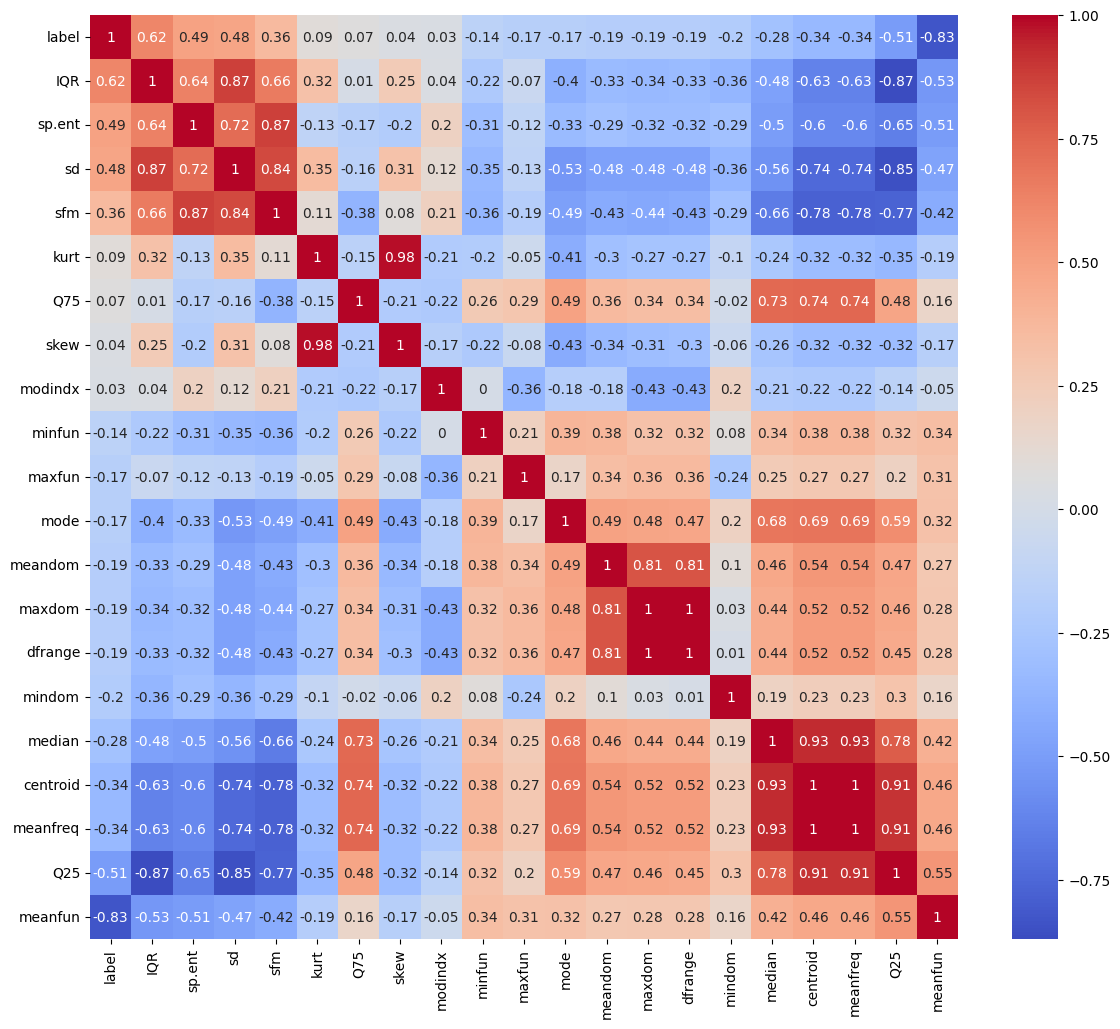

In [241]:
corplot(data)

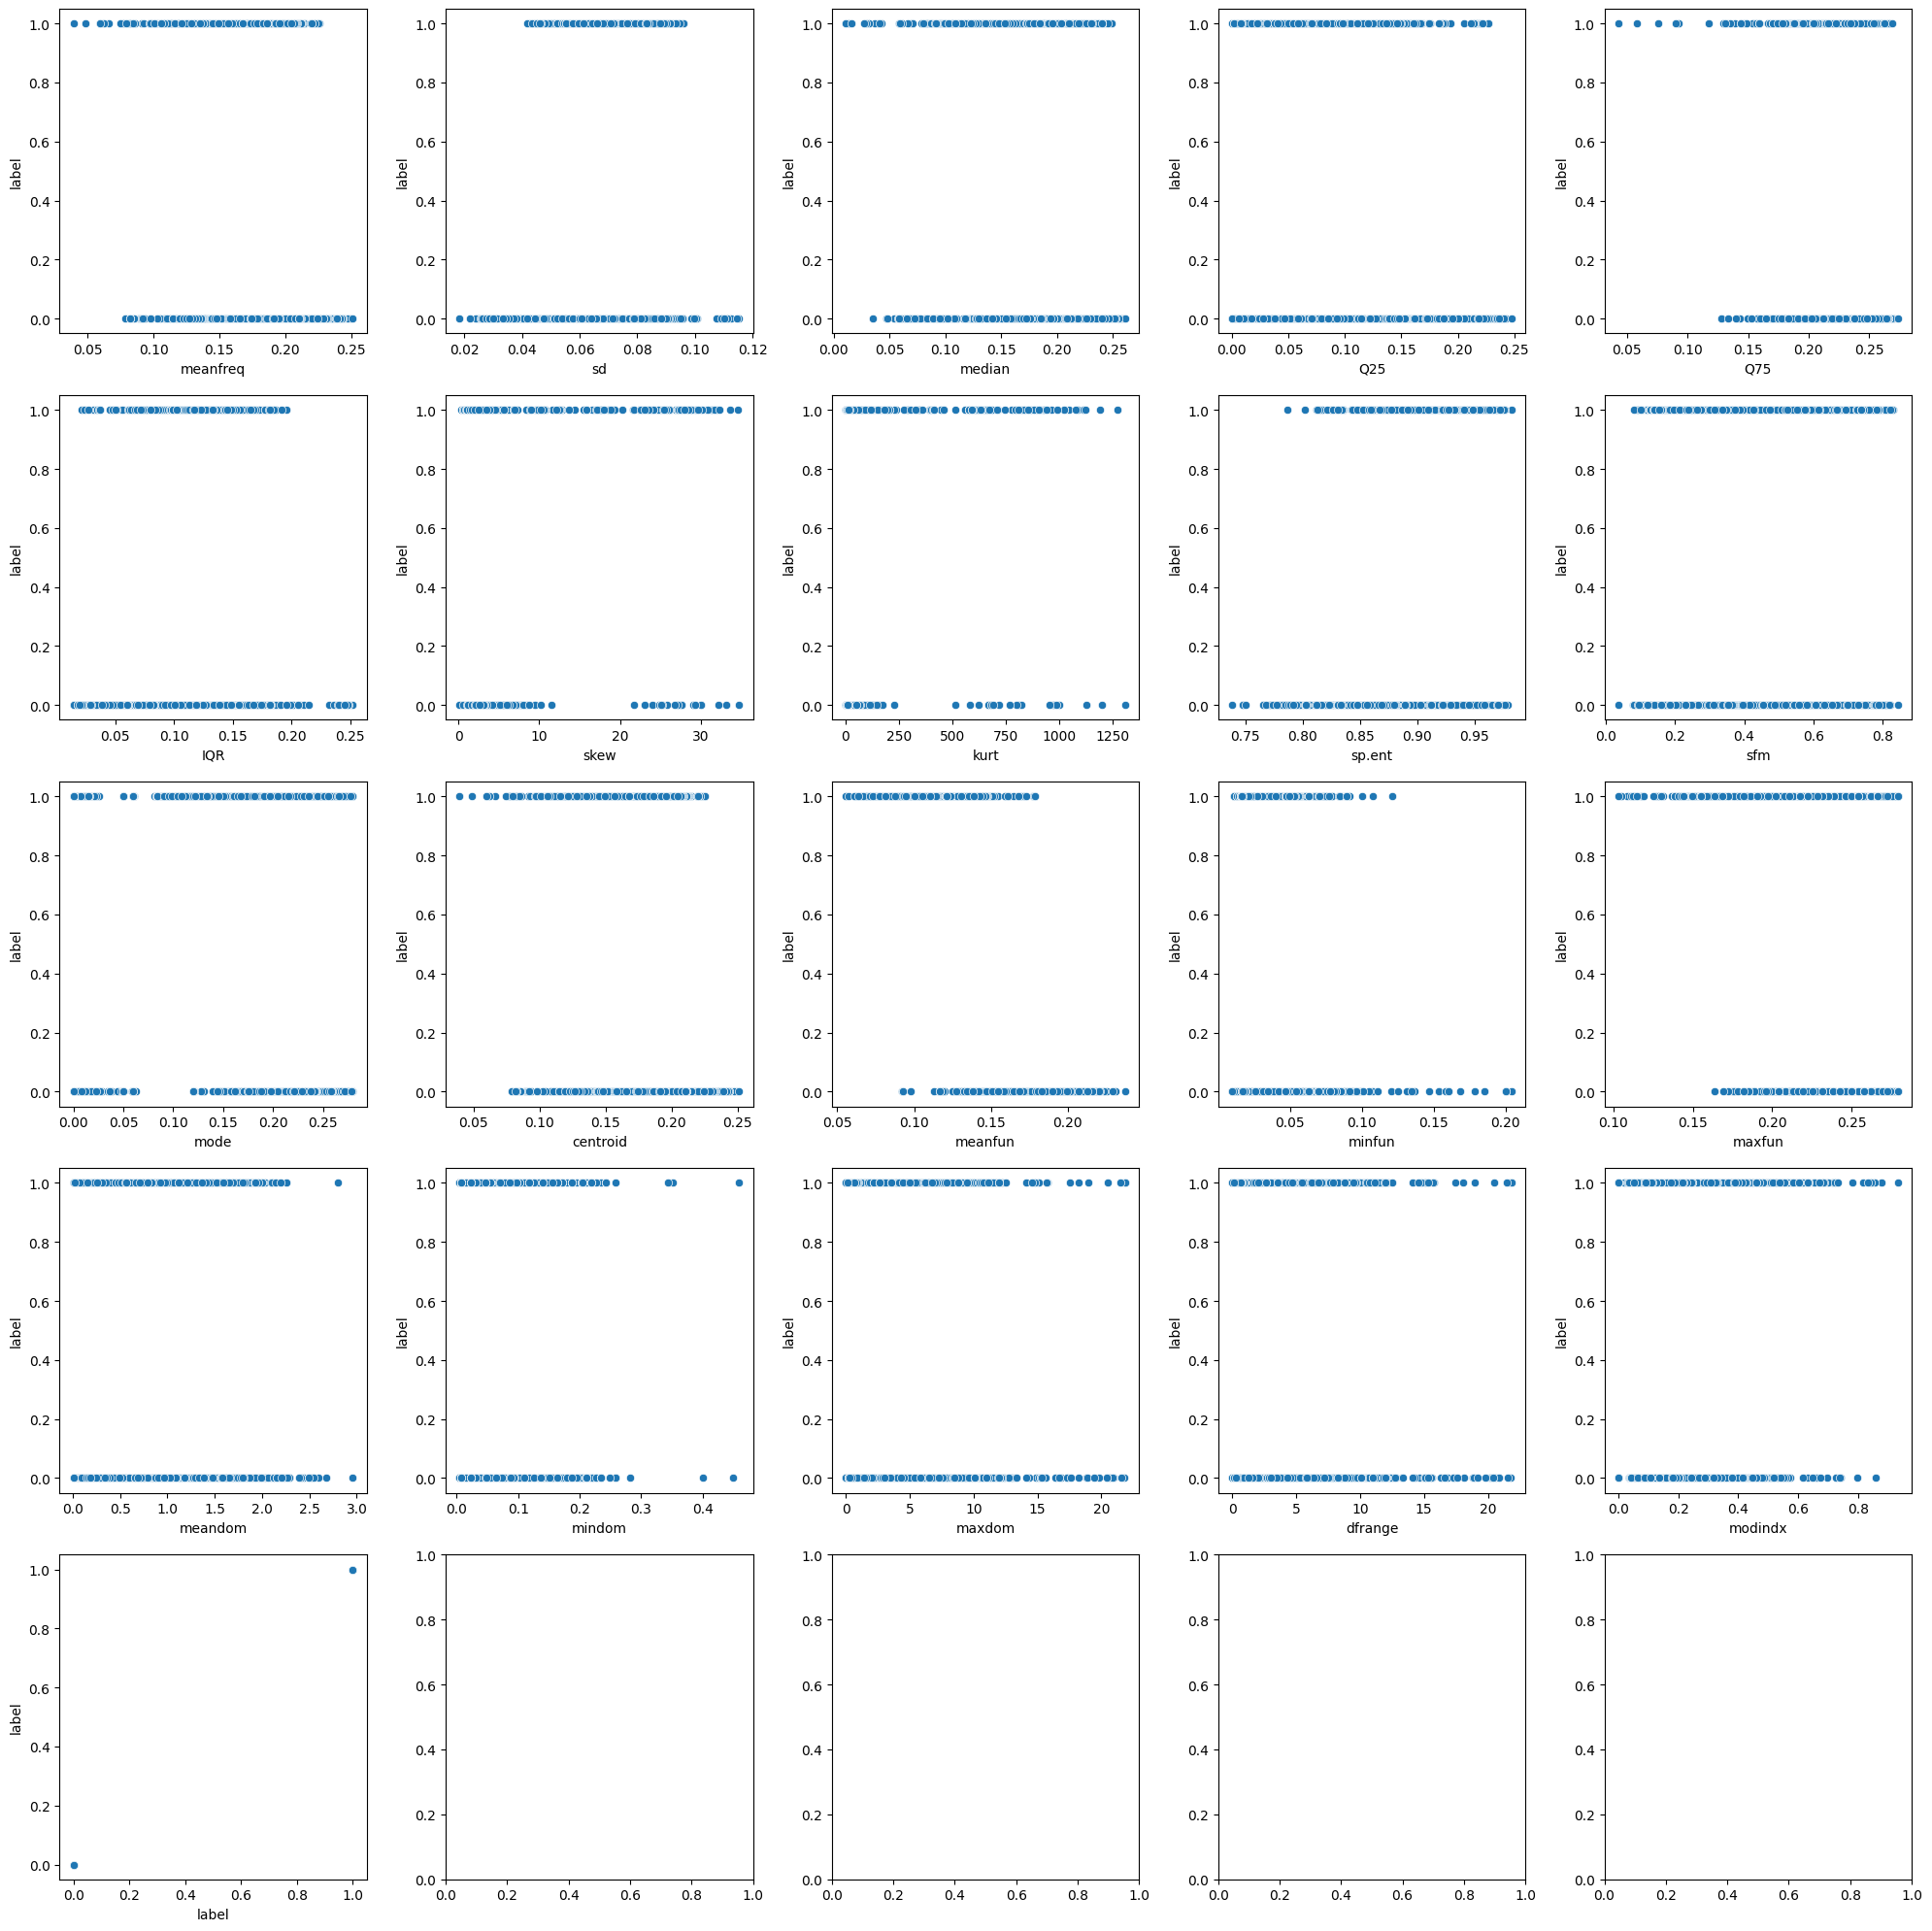

In [242]:
pairplots(data)

Well, what did you expect from pairplots and corr for statistics? IQR is correlated with 1st quartile? mean - with mode meadian with centroid. yeeees. mean is negativelly correlated with 'male'? lol

## Perceptron

Lets write a func to evaluate results

In [243]:
def print_score(y:pd.Series, y_pred:np.ndarray, name:str = 'Train')-> None:
  '''prints statistics for classification model'''
  print(name+' stats:')
  print(name+' accuracy: ', accuracy_score(y, y_pred > 0.2))
  print(name+' F measure: ', f1_score(y, y_pred > 0.2))
  print(name+' ROC-AUC: ', roc_auc_score(y, y_pred))
  print()

In [244]:
def run(model, X:pd.DataFrame, y:pd.Series, name:str = 'Train')-> None:
  y_pred = model.predict(X)
  print_score(y, y_pred, name)

In [245]:
def plot_loss(losses:list)->None:
  """plot loss value by iteration"""
  plt.plot(losses)
  plt.title('Loss function')
  plt.xlabel('Iterations')
  plt.ylabel('Loss value')
  plt.show()

### First we write custom perceptron class

In [263]:
class MyPerceptron:
  def __init__(self, w=None, b=0):
    self.w = w
    self.b = b

  @staticmethod
  def loss(y_pred:np.array, y:np.array)->np.array:
    '''mse'''
    return 1/2 * np.mean(y_pred-y)**2

  def init_wnb(self, x:pd.DataFrame)->None:
    '''zero weights for gradient'''
    self.w = np.zeros((x.shape[1], 1))
    self.b = 0

  def activate(self, n:pd.DataFrame)->np.array:
    '''threshold activation function'''
    return np.array(n > 0, dtype=np.int32)

  def predict(self, X:pd.DataFrame)-> np.array:
    """forward pass function"""
    return self.activate(X @ self.w + self.b)
  
  def backpropogation(self, X:pd.DataFrame, y:np.array, y_pred:np.array, lr:float = 5e-3)->None:
    '''backward pass function that updates weights and biases'''
    self.w = self.w - lr * (X.T @ (y_pred-y) / len(y))
    self.b = self.b - lr * np.mean(y_pred-y)
  
  def fit(self, X:pd.DataFrame, y:pd.Series, n_iters:int = 300)->list:
    self.init_wnb(X)
    y = y.values.reshape((-1,1))
    losses = []

    for n in range(n_iters):
      y_pred = self.predict(X)
      losses.append(self.loss(y_pred, y))
      self.backpropogation(X, y ,y_pred)
    return losses

###Split data

In [247]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['label']), data['label'], test_size = 0.3, random_state=42)

### Fit to custom perceptron

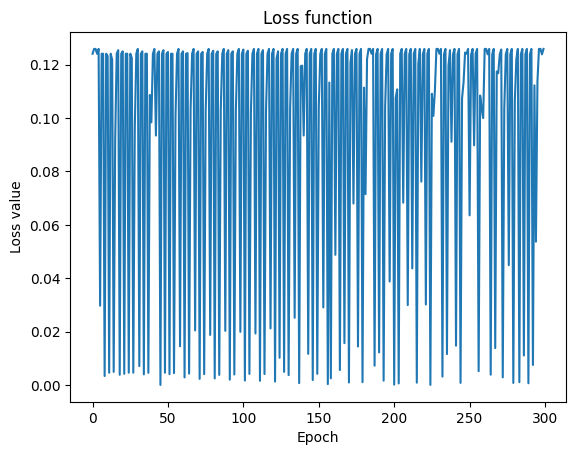

Train stats:
Train accuracy:  0.5180505415162455
Train F measure:  0.4408376963350785
Train ROC-AUC:  0.5175587790637056

Test stats:
Test accuracy:  0.49157894736842106
Test F measure:  0.40736196319018403
Test ROC-AUC:  0.49281057050029037



In [248]:
perc = MyPerceptron()
loses = perc.fit(X_train, y_train)
plot_loss(loses)
run(perc, X_train, y_train)
run(perc, X_test, y_test, 'Test')

Oh my. A shot in th dark. Try more iterations.

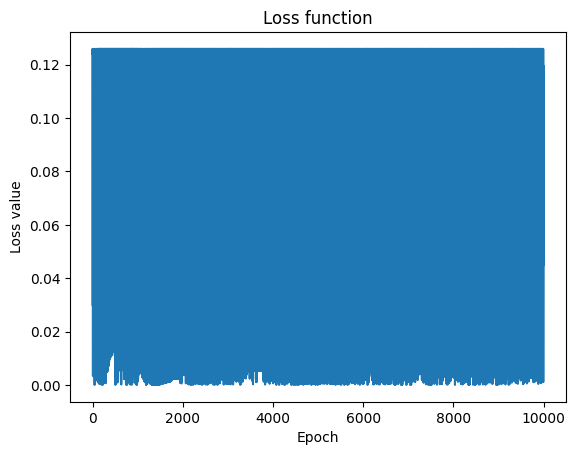

Train stats:
Train accuracy:  0.6024368231046932
Train F measure:  0.43197936814958093
Train ROC-AUC:  0.6013613022625377

Test stats:
Test accuracy:  0.6178947368421053
Test F measure:  0.45413533834586467
Test ROC-AUC:  0.6204650523693647



In [249]:
perc = MyPerceptron()
loses = perc.fit(X_train, y_train, 10000)
plot_loss(loses)
run(perc, X_train, y_train)
run(perc, X_test, y_test, 'Test')

Didn't help much.

### Sklearn perceptron

In [250]:
sk_perc = skPerceptron(random_state=42)
sk_perc.fit(X_train, y_train)
run(sk_perc, X_train, y_train)
run(sk_perc, X_test, y_test, 'Test')

Train stats:
Train accuracy:  0.5040613718411552
Train F measure:  0.0108010801080108
Train ROC-AUC:  0.502267751016578

Test stats:
Test accuracy:  0.4968421052631579
Test F measure:  0.004166666666666667
Test ROC-AUC:  0.5010438413361169



More iterations!

In [251]:
sk_perc = skPerceptron(max_iter = 10000, random_state=42)
sk_perc.fit(X_train, y_train)
run(sk_perc, X_train, y_train)
run(sk_perc, X_test, y_test, 'Test')

Train stats:
Train accuracy:  0.5040613718411552
Train F measure:  0.0108010801080108
Train ROC-AUC:  0.502267751016578

Test stats:
Test accuracy:  0.4968421052631579
Test F measure:  0.004166666666666667
Test ROC-AUC:  0.5010438413361169



Maybe outliers play important role? Lets cut IQR outliers.

In [252]:
def cut_iqr(df:pd.DataFrame, col:'str', mult: int = 3)-> pd.DataFrame:
  '''cuts rows to col's iqr max'''
  d=df[col].describe()
  val =(d['50%'] + (d['75%']-d['25%'])) * mult
  return df[df[col] <= val]

In [253]:
data1 = data.copy()
for col in data1.columns:
  data1 = cut_iqr(data1, col)

X1_train, X1_test, y1_train, y1_test = train_test_split(data1.drop(columns = ['label']), data1['label'], test_size = 0.3, random_state=42)

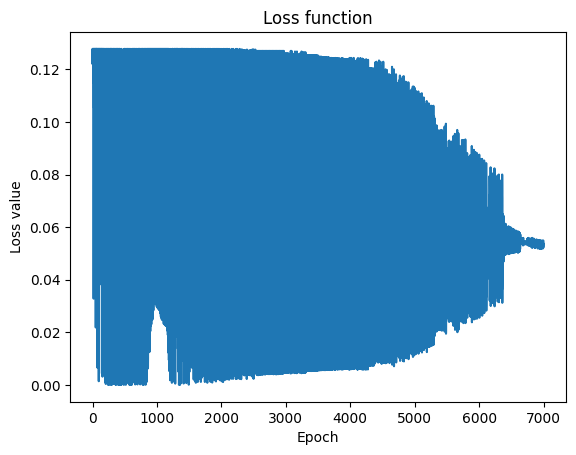

Train stats:
Train accuracy:  0.6718522119591638
Train F measure:  0.7502774694783573
Train ROC-AUC:  0.6754481506693897

Test stats:
Test accuracy:  0.6428571428571429
Test F measure:  0.7300771208226222
Test ROC-AUC:  0.651322288536736



In [254]:
perc1 = MyPerceptron()
loses1 = perc1.fit(X1_train, y1_train, 7000)
plot_loss(loses1)
run(perc1, X1_train, y1_train)
run(perc1, X1_test, y1_test, 'Test')

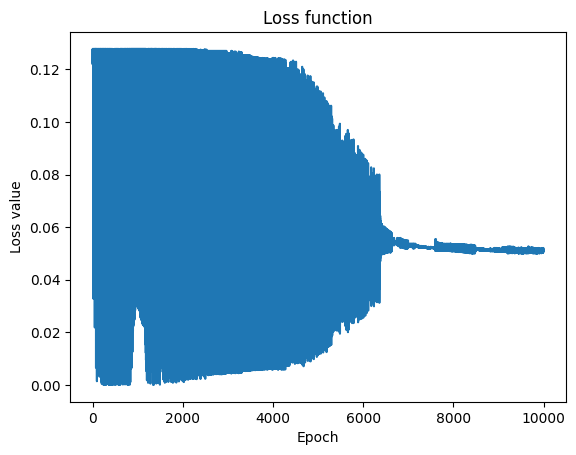

Train stats:
Train accuracy:  0.681575109382596
Train F measure:  0.7564150241725548
Train ROC-AUC:  0.6850961538461539

Test stats:
Test accuracy:  0.6541950113378685
Test F measure:  0.7377472055030094
Test ROC-AUC:  0.6625540234616176



In [255]:
perc1 = MyPerceptron()
loses1 = perc1.fit(X1_train, y1_train, 10000)
plot_loss(loses1)
run(perc1, X1_train, y1_train)
run(perc1, X1_test, y1_test, 'Test')

Looks like cutting outlier has helped. Btw the loss has actually grown a bit after 7k iterations!

In [256]:
sk_perc1 = skPerceptron(max_iter = 10000, random_state = 42)
sk_perc1.fit(X1_train, y1_train)
run(sk_perc1, X1_train, y1_train)
run(sk_perc1, X1_test, y1_test, 'Test')

Train stats:
Train accuracy:  0.6971317452600875
Train F measure:  0.620815581253804
Train ROC-AUC:  0.6949682323576128

Test stats:
Test accuracy:  0.7018140589569161
Test F measure:  0.6215827338129497
Test ROC-AUC:  0.6969592508746656



Here the simple custom Perceptron performed better than sklearn one, but the performance of the latter one actually depends on different random states. Anyways, custom one shows a bit better result in vast amount of runs.

So...In general perceptron isn't really good at tasks like this. Guess too much parameters for it, the outliers might have played a role, another activation function might be better. Finally, let's try A LOT of iterations.

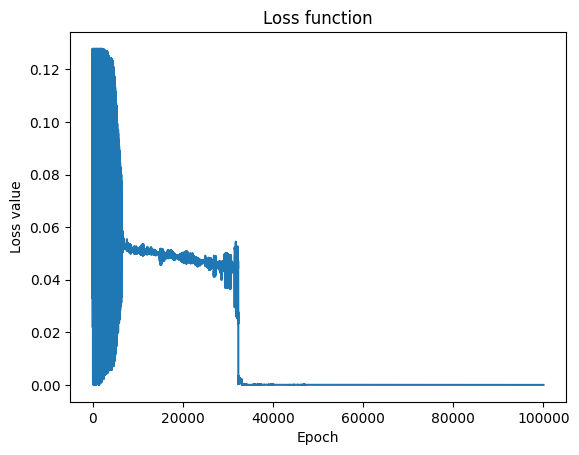

Train stats:
Train accuracy:  0.9669421487603306
Train F measure:  0.9665354330708661
Train ROC-AUC:  0.96692714242493

Test stats:
Test accuracy:  0.9625850340136054
Test F measure:  0.9617612977983777
Test ROC-AUC:  0.962646635110105



In [261]:
perc1 = MyPerceptron()
loses1 = perc1.fit(X1_train, y1_train, 100000)
plot_loss(loses1)
run(perc1, X1_train, y1_train)
run(perc1, X1_test, y1_test, 'Test')

In [271]:
y1_pred_train = perc1.predict(X1_train)
print(perc1.loss(y1_pred_train.ravel(), y1_train))
y1_pred_test = perc1.predict(X1_test)
print(perc1.loss(y1_pred_test.ravel(), y1_test))

4.726736715329209e-07
5.7846267758804195e-06


Marvelous! Didn't expect that. So after a long time it has reached a neat minimum. Perfect. But takes too long.


Lets try a simple LinearRegression.

##Linear Classifier

In [257]:
model = LinearRegression()
model.fit(X_train, y_train)
run(model, X_train, y_train)
run(model, X_test, y_test, 'Test')

Train stats:
Train accuracy:  0.8447653429602888
Train F measure:  0.8642462509865825
Train ROC-AUC:  0.9922347448128453

Test stats:
Test accuracy:  0.8357894736842105
Test F measure:  0.858695652173913
Test ROC-AUC:  0.9905766170675815



In [258]:
model1 = LinearRegression()
model1.fit(X1_train, y1_train)
run(model1, X1_train, y1_train)
run(model1, X1_test, y1_test, 'Test')

Train stats:
Train accuracy:  0.8424890617403986
Train F measure:  0.8615384615384616
Train ROC-AUC:  0.9921242719915286

Test stats:
Test accuracy:  0.8537414965986394
Test F measure:  0.8685015290519879
Test ROC-AUC:  0.9896840913768266



Nuff said.